In [3]:
from inference import get_model
import supervision as sv
from inference.core.utils.image_utils import load_image_bgr

In [ ]:
from PIL import Image
import numpy as np
import os

def load_images_from_folder_pillow(folder):
    images = []
    for filename in os.listdir(folder):
        try:
            img = Image.open(os.path.join(folder, filename)).convert('RGB') # Explicitly convert to RGB
            img_array = np.array(img)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            continue  # Skip to the next image

    return np.array(images)

# Example usage:
folder_path = "./extracted_frames" # Replace with the actual path
image_arrays = load_images_from_folder_pillow(folder_path)

In [53]:
image = image_arrays[8]

# Yolov5

In [56]:
import torch

model = torch.hub.load("ultralytics/yolov5", 'custom', path='yolov5s.pt')
model.classes = [0]  # Only person
model.conf = 0.5

Using cache found in /home/mariia/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-3-1 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

100%|██████████| 14.1M/14.1M [00:01<00:00, 11.4MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


image 1/1: 480x640 (no detections)
Speed: 2.9ms pre-process, 65.9ms inference, 58.9ms NMS per image at shape (1, 3, 480, 640)


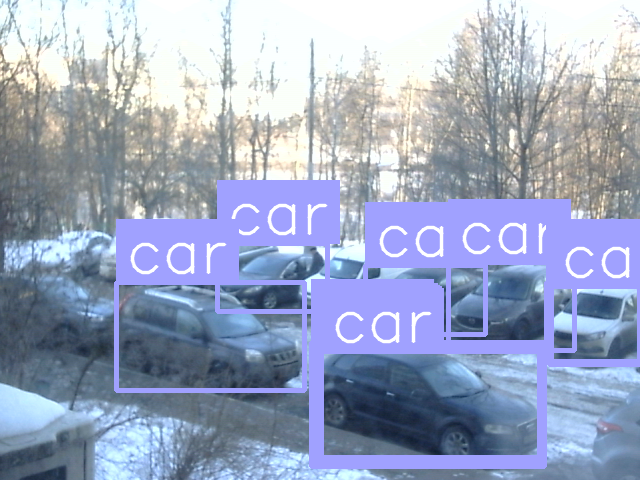

In [57]:
results = model(image)

# Results
results.print()
results.show()

# Yolov8

In [54]:
model = get_model(model_id="yolov8n-640")
results = model.infer(image)[0]
results = sv.Detections.from_inference(results)
annotator = sv.BoxAnnotator(thickness=4)
annotated_image = annotator.annotate(image, results)
annotator = sv.LabelAnnotator(text_scale=2, text_thickness=2)
annotated_image = annotator.annotate(annotated_image, results)
sv.plot_image(annotated_image)

# Person-detection-yucm9/1

In [58]:
from inference_sdk import InferenceHTTPClient
import cv2

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="DEjLPJ8ox06Svxy1X1ig"
)

result = CLIENT.infer(image, model_id="person-detection-yucm9/1")
result

{'inference_id': '8d23c465-4aec-4e57-9b4f-95cb9a7220aa',
 'time': 0.04224661599982937,
 'image': {'width': 640, 'height': 480},
 'predictions': [{'x': 210.5,
   'y': 336.0,
   'width': 189.0,
   'height': 110.0,
   'confidence': 0.9405891299247742,
   'class': 'face',
   'class_id': 0,
   'detection_id': '99f6635c-f293-4a8c-95ec-96de31cc2017'},
  {'x': 433.0,
   'y': 405.0,
   'width': 220.0,
   'height': 106.0,
   'confidence': 0.9126190543174744,
   'class': 'person',
   'class_id': 1,
   'detection_id': '946be470-f341-4ebe-b821-0903ac6d5b6d'},
  {'x': 592.0,
   'y': 323.0,
   'width': 94.0,
   'height': 74.0,
   'confidence': 0.4350842833518982,
   'class': 'face',
   'class_id': 0,
   'detection_id': '68ef0c5f-55b7-4f01-aa34-f079cc506380'}]}

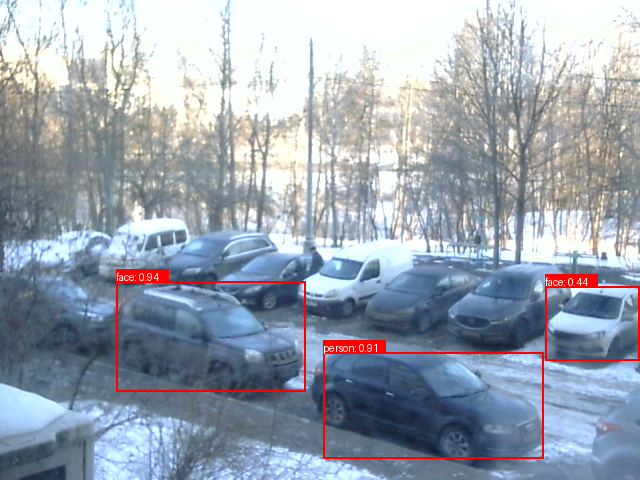

In [59]:
from PIL import Image, ImageDraw

img = Image.open('extracted_frames/opencv8.png')
draw = ImageDraw.Draw(img)

for prediction in result['predictions']:
    x = prediction['x']
    y = prediction['y']
    width = prediction['width']
    height = prediction['height']
    confidence = prediction['confidence']
    class_name = prediction['class']
    # Calculate the bounding box coordinates
    x1 = x - (width / 2)  # Top-left x coordinate
    y1 = y - (height / 2) # Top-left y coordinate
    x2 = x + (width / 2)  # Bottom-right x coordinate
    y2 = y + (height / 2) # Bottom-right y coordinate

    # Draw the bounding box
    draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=2)  # Red box

    # Add label with class name and confidence
    label = f"{class_name}: {confidence:.2f}" # class name + confidence
    label_position = (x1, y1 - 10)  # Position label above box

    # Handle possible errors with text size calculations:
    try:
        text_width, text_height = draw.textsize(label)
    except AttributeError:
        text_width = len(label) * 5 # simple estimate of width of string
        text_height = 10

    # Draw the label background
    draw.rectangle((x1, y1 - text_height - 2, x1 + text_width + 2, y1), fill="red")

    # Draw the label text
    draw.text(label_position, label, fill="white")
img.show()  # Show the image (platform-dependent)
# save_path = "output.jpg"  # Specify a save path
# img.save(save_path)
# print(f"Image saved to {save_path}")